In [2]:
!pip install yfinance
!pip install transformers
!pip install datasets
!pip install textblob

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from transformers import pipeline
from textblob import TextBlob
import datetime

In [5]:
ticker = 'AAPL'  # Change to any valid stock symbol
today = datetime.date.today()
df = yf.download(ticker, start='2020-01-01', end=today)
data = df[['Close']].values

<ipython-input-5-2497902735>:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01', end=today)
[*********************100%***********************]  1 of 1 completed


In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [7]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=5, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0444
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0016
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0012
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0011
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0011


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


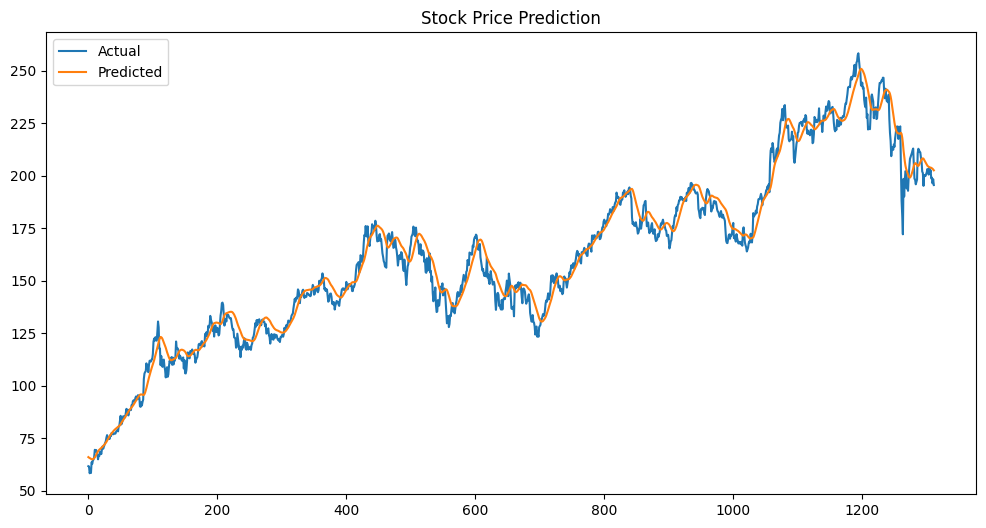

In [8]:
predicted = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y)

plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='Predicted')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

Day 1: $202.18
Day 2: $201.96
Day 3: $201.87
Day 4: $201.87
Day 5: $201.94
Day 6: $202.05
Day 7: $202.19


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


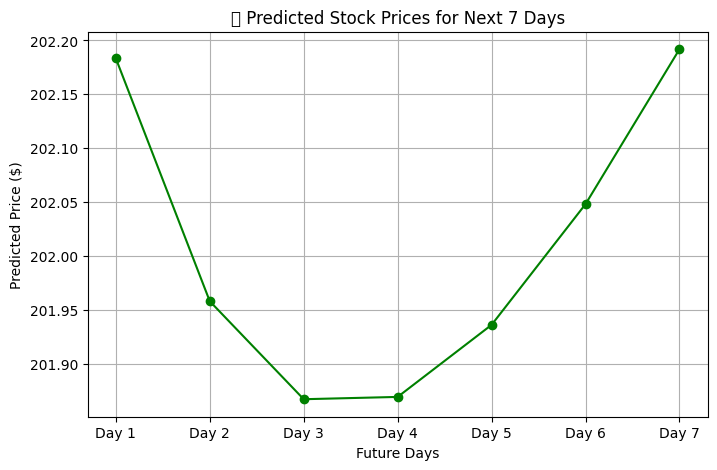

In [15]:
future_predictions = []
last_60 = scaled_data[-60:].tolist()

for _ in range(7):
    X_input = np.array([last_60[-60:]])
    X_input = X_input.reshape(1, 60, 1)
    pred = model.predict(X_input, verbose=0)
    future_predictions.append(pred[0][0])
    last_60.append(pred[0])

future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Print prices
for i, price in enumerate(future_prices):
    print(f"Day {i+1}: ${price[0]:.2f}")

# Plot graph
plt.figure(figsize=(8, 5))
plt.plot(future_prices, marker='o', color='green')
plt.title('📈 Predicted Stock Prices for Next 7 Days')
plt.xlabel('Future Days')
plt.ylabel('Predicted Price ($)')
plt.grid(True)
plt.xticks(ticks=range(7), labels=[f"Day {i+1}" for i in range(7)])
plt.show()

In [16]:
news_text = """
Apple is expected to release its new lineup of products at the WWDC event, with analysts predicting strong sales growth.
Investors are watching closely as the company continues its expansion into AI and subscription services.
"""

summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small")
summary = summarizer("summarize: " + news_text, max_length=50, min_length=25, do_sample=False)
print("🧠 Summary of Financial News:")
print(summary[0]['summary_text'])

Device set to use cpu
Your max_length is set to 50, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


🧠 Summary of Financial News:
analysts predict strong sales growth as the company continues its expansion into AI and subscription services . the company is expected to release its new lineup at the WWDC event .


In [17]:
blob = TextBlob(news_text)
print("🧠 Sentiment Polarity:", blob.sentiment.polarity)

if blob.sentiment.polarity > 0:
    print("✅ Sentiment: Positive")
elif blob.sentiment.polarity < 0:
    print("❌ Sentiment: Negative")
else:
    print("➖ Sentiment: Neutral")

🧠 Sentiment Polarity: 0.15656565656565655
✅ Sentiment: Positive


In [12]:
from transformers import pipeline
generator = pipeline("text-generation", model="gpt2")
input_text = "Based on the stock forecast and news sentiment, the recommendation is"
result = generator(input_text, max_length=50, num_return_sequences=1)
print("💬 AI Recommendation:")
print(result[0]['generated_text'])

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


💬 AI Recommendation:
Based on the stock forecast and news sentiment, the recommendation is based on the market's best estimate of future revenue and expenditures.

To understand what would happen in the future, we recommend that you read the following:

Investing In The Future

On this page, we will explain how to start investing in the future in a short and simple way:

By using the "Funding" tab on the left side of this page, you can choose from a number of different types of funds.

If you have trouble with each of them, you can simply refer to this website for the information on how to get started on a new fund.

For more information about investing in the future, read this article:

How to Invest In The Future

If you are interested in investing in the future, I highly recommend this article:

How to Invest In The Future: A Beginner's Guide

Before you begin, I would like to make a recommendation that you should start investing in the future at least once. In this article, I will 

In [13]:
df['Returns'] = df['Close'].pct_change()
volatility = df['Returns'].std()
print(f"📊 Price Volatility: {volatility:.4f}")

if volatility > 0.02:
    print("⚠️ High Risk")
else:
    print("✅ Low Risk")

📊 Price Volatility: 0.0206
⚠️ High Risk


In [18]:
future_df = pd.DataFrame({
    'Day': [f"Day {i+1}" for i in range(7)],
    'Predicted_Price': future_prices.flatten()
})
future_df.to_csv('stock_report.csv', index=False)
print("✅ Report saved as stock_report.csv")

✅ Report saved as stock_report.csv


In [19]:
from datetime import datetime, timedelta

start_date = datetime.today()
date_labels = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(1, 8)]

# Print predictions with dates
print("📅 Predicted Prices for the Next 7 Days:")
for date, price in zip(date_labels, future_prices):
    print(f"{date} → ${price[0]:.2f}")

📅 Predicted Prices for the Next 7 Days:
2025-06-19 → $202.18
2025-06-20 → $201.96
2025-06-21 → $201.87
2025-06-22 → $201.87
2025-06-23 → $201.94
2025-06-24 → $202.05
2025-06-25 → $202.19


<ipython-input-20-3637044784>:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


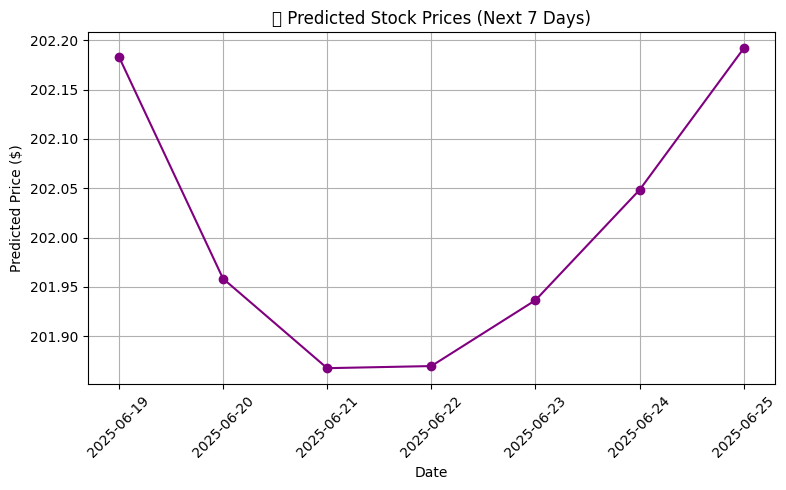

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(future_prices, marker='o', color='purple')
plt.title('📈 Predicted Stock Prices (Next 7 Days)')
plt.xlabel('Date')
plt.ylabel('Predicted Price ($)')
plt.xticks(ticks=range(7), labels=date_labels, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
report_df = pd.DataFrame({
    'Date': date_labels,
    'Predicted_Price': future_prices.flatten()
})

# Add sentiment and risk
report_df['News_Sentiment'] = blob.sentiment.polarity
report_df['Volatility'] = volatility

report_df.to_csv('full_stock_report.csv', index=False)
print("📄 Full report saved as 'full_stock_report.csv'")

📄 Full report saved as 'full_stock_report.csv'


In [22]:
risk_level = "High Risk" if volatility > 0.02 else "Low Risk"
sentiment_result = "Positive" if blob.sentiment.polarity > 0 else ("Negative" if blob.sentiment.polarity < 0 else "Neutral")

summary = f"""
📊 Summary Report for {ticker}
----------------------------------------
🔮 7-Day Price Trend:
   {' → '.join([f"${p[0]:.2f}" for p in future_prices])}

📰 News Sentiment: {sentiment_result}
📉 Volatility: {volatility:.4f} ({risk_level})

📌 Investment Advice:
   { "⚠️ High risk — stay alert!" if risk_level == "High Risk" else "👍 Low risk — stable opportunity." }
   { "🟢 Sentiment is Positive — trend may continue upward." if sentiment_result == "Positive" else "" }
"""
print(summary)


📊 Summary Report for AAPL
----------------------------------------
🔮 7-Day Price Trend:
   $202.18 → $201.96 → $201.87 → $201.87 → $201.94 → $202.05 → $202.19

📰 News Sentiment: Positive
📉 Volatility: 0.0206 (High Risk)

📌 Investment Advice:
   ⚠️ High risk — stay alert!
   🟢 Sentiment is Positive — trend may continue upward.

